# Data loading

In [25]:
import pandas as pd

In [26]:
df = pd.read_csv('data.csv')

In [27]:
df.sample(5)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
3225       3226    15785170      Neal          850   Germany  Female   32   
2071       2072    15697214   Korovin          686     Spain  Female   36   
9100       9101    15743075        Ko          659    France    Male   35   
4980       4981    15740406  Padovesi          628   Germany    Male   38   
2728       2729    15770420    Dillon          749   Germany    Male   46   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
3225       0  116968.91              1          0               0   
2071       5       0.00              2          1               1   
9100       6       0.00              2          1               1   
4980      10  113525.84              1          1               0   
2728      10   78136.36              2          1               1   

      EstimatedSalary  Exited  
3225        175094.62       0  
2071        152979.14       0  
9100         58879.11       0  
4980         46044.48       1  
2728         73470.98       0

# Baseline

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[df.columns[~df.columns.isin([
        'RowNumber','CustomerId','Surname','Geography','Exited', 'Gender'
        ])]], 
    df['Exited'], 
    test_size=0.2)

In [29]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train, eval_metric='auc')
y_pred = xgb.predict(X_test)

In [30]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.531810766721044

# Dataset overview

### Hists

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AA6686A080>,
      dtype=object)

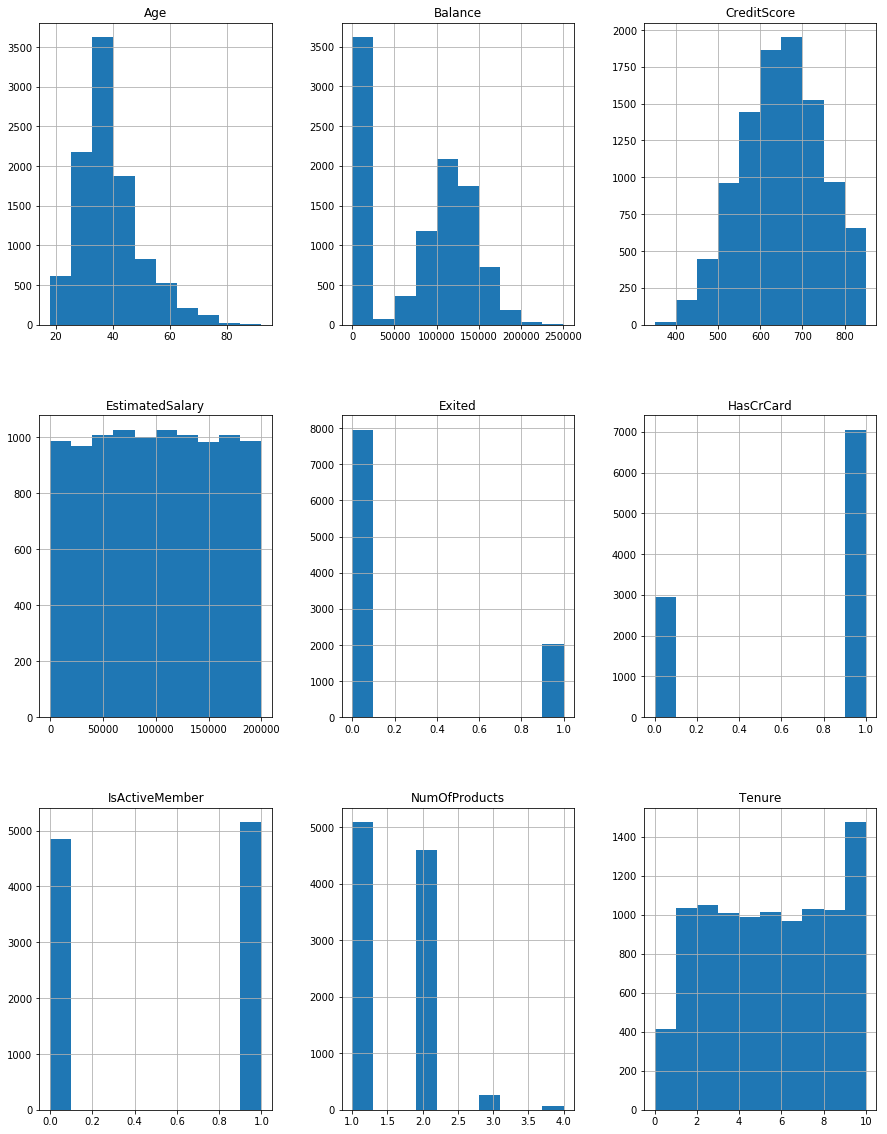

In [31]:
import matplotlib.pyplot as plt

hist_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
                  'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
fig = plt.figure(figsize = (15,20))
df[hist_columns].hist(ax = fig.gca())

Here we can see that EstimatedSalary is uniform so it is unlikely to influence the target  
Balance and NumOfProducts needs treating in a way of extreme values indicator  
...

### Corr matrix

In [32]:
import seaborn as sns

def plot_corr_matrix(df):
    colormap = plt.cm.hot_r
    plt.figure(figsize=(14,12))

    df_correlation = df.astype(float).corr().abs()
    sns.heatmap(df_correlation, 
                square=True, cmap=colormap, annot=True)

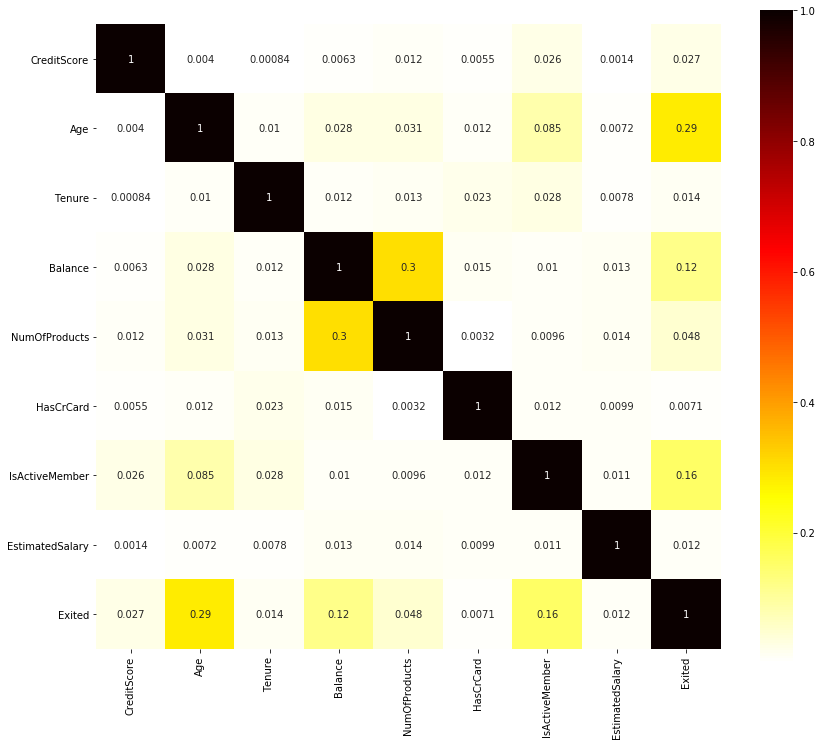

In [33]:
plot_corr_matrix(df[hist_columns])

# Features

### Engineering

In [34]:
df = df.drop(columns = ['RowNumber', 'CustomerId'])

In [35]:
df['Gender'] = df['Gender'].astype("category").cat.codes

df['_Geography_isFrance'] = (df['Geography'] == 'France').astype('int')
df['_Geography_isGermany'] = (df['Geography'] == 'Germany').astype('int')

df['_Balance_isEmpty'] = (df['Balance'] < 1e-3).astype('int')

df['_NumOfProducts_isLessThanThree'] = (df['NumOfProducts'] < 3).astype('int')

df['_Surname_Length'] = df['Surname'].apply(len)

vowels = df['Surname'].str.lower().str.count(r'[aeiou]')
consonants = df['Surname'].str.lower().str.count(r'[a-z]') - vowels
df['_Surname_vowelsPerConsonants'] = vowels / consonants

Some basic feature engineering (I've checked every feature contribution with 10FoldCV) and some experimental but pointless stuff with names 

In [36]:
df = df.drop(columns=['Surname', 'Geography'])

In [37]:
df.sample(5)

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
3458          770       0   37       9       0.00              2          0   
7109          670       0   39       8  101928.51              1          0   
8037          547       1   62      10  127738.75              2          1   
1351          648       0   54       9  120633.42              1          0   
7444          742       0   29       4       0.00              2          1   

      IsActiveMember  EstimatedSalary  Exited  _Geography_isFrance  \
3458               0         22710.72       0                    1   
7109               0         89205.54       0                    1   
8037               1         85153.00       0                    1   
1351               0          5924.38       1                    1   
7444               1        180066.59       0                    1   

      _Geography_isGermany  _Balance_isEmpty  _NumOfProducts_isLessThanThree  \
3458                     0                 1                               1   
7109                     0                 0                               1   
8037                     0                 0                               1   
1351                     0                 0                               1   
7444                     0                 1                               1   

      _Surname_Length  _Surname_vowelsPerConsonants  
3458                6                      1.000000  
7109                4                      0.333333  
8037                4                      1.000000  
1351                5                      0.666667  
7444                8                      0.333333

### New corr matrix

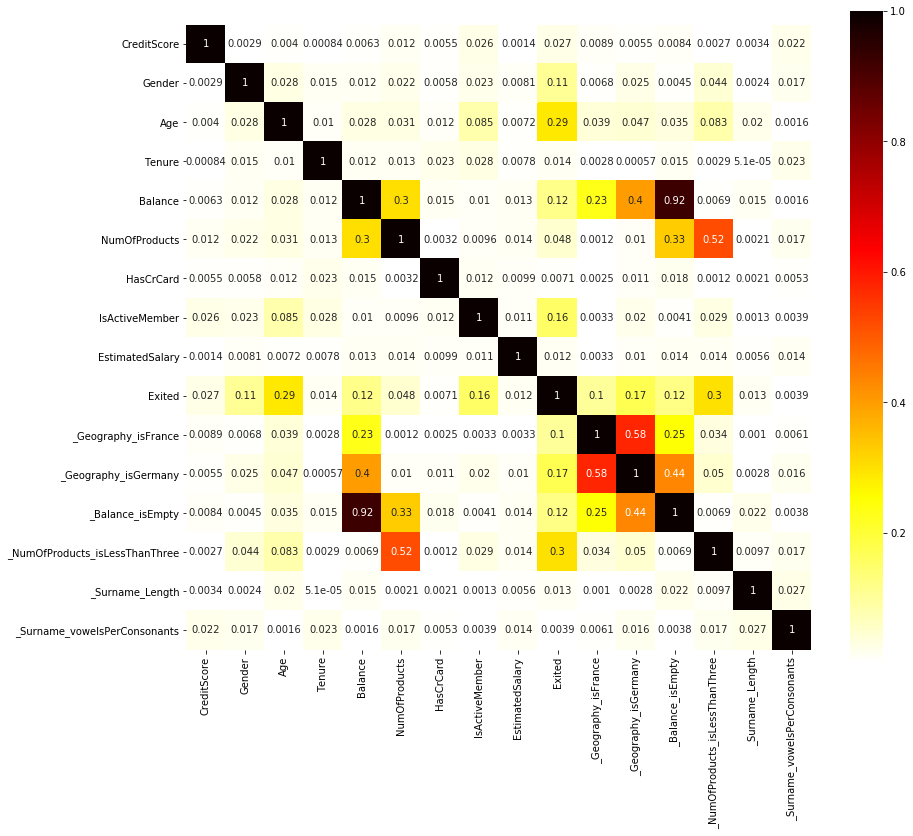

In [38]:
plot_corr_matrix(df)

Here we can see that many features are correlated with the target  
I've explicitly decided not to delete ones that are correlated between each other

# Checking new features

### Baseline solution

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Exited']), 
    df['Exited'], 
    test_size=0.2)

In [40]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train, eval_metric='auc')
y_pred = xgb.predict(X_test)

f1_score(y_test, y_pred)

0.5824

You can perform automatic multiple testing to average the results and new features work better

### Sample stacking

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from vecstack import stacking

models = [
    KNeighborsClassifier(n_neighbors=5,
                        n_jobs=-1),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=3),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3)
]

S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=False, 
                           mode='oof_pred_bag', 
                           needs_proba=False,
                           save_dir=None, 
                           metric=f1_score, 
                           n_folds=4, 
                           stratified=True,
                           shuffle=True,  
                           random_state=0,    
                           verbose=2)

model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=3)
    
model = model.fit(S_train, y_train)
y_pred = model.predict(S_test)
print('Final prediction score: [%.8f]' % f1_score(y_test, y_pred))

task:         [classification]
n_classes:    [2]
metric:       [f1_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.13035382]
    fold  1:  [0.09335727]
    fold  2:  [0.15526802]
    fold  3:  [0.13308688]
    ----
    MEAN:     [0.12801650] + [0.02222093]
    FULL:     [0.12775735]

model  1:     [RandomForestClassifier]
    fold  0:  [0.23880597]
    fold  1:  [0.24733475]
    fold  2:  [0.22077922]
    fold  3:  [0.19047619]
    ----
    MEAN:     [0.22434903] + [0.02177992]
    FULL:     [0.22448980]

model  2:     [XGBClassifier]
    fold  0:  [0.57185185]
    fold  1:  [0.59282371]
    fold  2:  [0.57507987]
    fold  3:  [0.55641422]
    ----
    MEAN:     [0.57404241] + [0.01293605]
    FULL:     [0.57396678]

Final prediction score: [0.57827476]


I haven't put much into stacking, but I've had an intuition (that confirmed to be right later) that it is not the issue with the model

# Conf matrix

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1555,   43],
       [ 221,  181]], dtype=int64)

# Dealing with an imbalance

In [43]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [44]:
import numpy as np

xgb = XGBClassifier()
xgb.fit(X_sm, y_sm, eval_metric='auc')
y_pred = xgb.predict(np.array(X_test))

f1_score(y_test, y_pred)

0.6232294617563738

In [45]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.867

# Data structure visualization

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

In [47]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

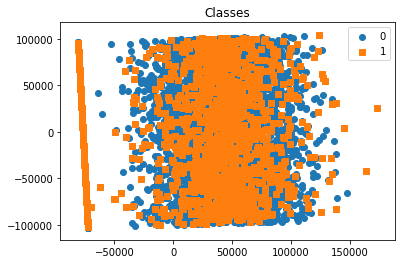

In [48]:
plot_2d_space(X_train_pca, y_train)

We can clearly see that simple subspace transformation can't separate the target domain, except of the straght line (I suspect these are the ones with zero Balance)

# Discussion

### What could I do to increase the performance

* Feature engineering: check out feature importance (I've done it, but didn't apply), investigate important combinations of features on different models
* Continue with models: stacking, blending, bagging (I don't think the problem is in model, it is rather in data)
* Over/Sub sample data with different algorithms (either interpolating or duplicating). I've did interpolating oversampling, but only using one approach
* Look on the data space: plot TSNE (it gives non-separable projection), project NN embeddings to see the data space structure